In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


In [ ]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [ ]:
%cd /content/stylegan2

/content/stylegan2


In [ ]:
!pip install googledrivedownloader

In [ ]:
import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

#url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
url = 'https://drive.google.com/open?id=1YckI8gwqPbZBI8X4eaQAJCgWx-CqCTdi'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
!pip install tqdm

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r -v "/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg" "/content/"

'/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2019.11.13-22.23.59].csv' -> '/content/eeg/record-[2019.11.13-22.23.59].csv'
'/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2020.06.28-00.36.11].csv' -> '/content/eeg/record-[2020.06.28-00.36.11].csv'
'/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2020.06.29-19.49.23].csv' -> '/content/eeg/record-[2020.06.29-19.49.23].csv'
'/content/gdrive/MyDrive/EEG-GAN-audio-video/eeg/record-[2020.06.28-14.26.09].csv' -> '/content/eeg/record-[2020.06.28-14.26.09].csv'


In [ ]:
!pip install mne


In [ ]:
import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, compute_source_psd

import pandas as pd
import numpy as np


In [ ]:
    key = 0
    idx = 0

    data_path = '/content/eeg'
    #raw_fname = data_path + '/record-[2019.11.13-22.23.59].gdf'
    #raw = mne.io.read_raw_gdf(raw_fname, preload=True)

    path = data_path
    #ch_names = ['FP1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7','P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2','C4','T8','FC6','FC2','F4','F8','AF4','FP2','Fz','Cz']
    #data = pd.read_csv(path + '/record-[2019.11.13-22.23.59].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    ch_names = ['FP1','F3','P3','O1','O2','P4','F4','FP2']
    #data = pd.read_csv(path + '/record-[2020.06.28-00.36.11].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    data = pd.read_csv(path + '/record-[2020.06.28-14.26.09].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    #data = pd.read_csv(path + '/record-[2020.06.29-19.49.23].csv', skiprows=0, usecols=ch_names, header=0, delimiter=';') 
    
    #print(data)
    data_transpose=np.transpose(data)

    sfreq = 512 
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq)
    #info = mne.create_info(sfreq = sfreq)
    raw = mne.io.RawArray(data_transpose, info)
    #raw.plot()

    # Setup for reading the raw data
    #raw = io.read_raw_fif(raw_fname, verbose=False)
    #events = mne.find_events(raw, stim_channel='STI 014')
    #inverse_operator = read_inverse_operator(fname_inv)
    #raw.info['bads'] = ['MEG 2443', 'EEG 053']

    # picks MEG gradiometers
    #picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False)
    picks = ch_names

Creating RawArray with float64 data, n_channels=8, n_times=844096
    Range : 0 ... 844095 =      0.000 ...  1648.623 secs
Ready.


In [ ]:
#!pip install imageio==2.9
!pip install imageio==2.4.1
!pip install imageio-ffmpeg==0.4.3 pyspng==0.1.0

     |████████████████████████████████| 26.9MB 111kB/s 
     |████████████████████████████████| 204kB 36.3MB/s 


In [ ]:
!mkdir '/content/out'

In [ ]:
import imageio
fps=10
out = imageio.get_writer('/content/out/output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')
#for img in imgs:
#  out.append_data(np.asarray(img))
#out.close()
            

In [ ]:
import logging
logging.basicConfig(level='warning')


In [ ]:
# Generate random breaks and display audio

# CHANGE THIS to change number of examples generated
#n_generate = 30
#n_generate = 150
#n_generate = 300
#n_generate = 305
#n_generate = 390

# Sample latent vectors
#seed = 666 # change this seed to generate different set of breaks
#np.random.seed(seed)
#_z = (np.random.rand(n_generate, dim) * 2.) - 1.


hz=44100
#hz=39936
#hz=int(32768*2*(600/240))
#hz=int(32768*2*(480/240))
#hz=int(32768*2*(360/240))
#hz=int(32768*2*(300/240))
#hz=int(32768*2*(265/240))
#hz=int(32768*2*(250/240))
#hz=int(32768*2*(240/240)*1.6666666)
#hz=int(32768*2*(240/240))
#hz=int(32768*2*(120/240))
#fps=hz/(32768*2)
#fps=10
#fps=0.5
#fps=44100/(32768*2)
#fps=1
#fps=1/3
#fps=1.5

#n_generate=int((307-2)*fps)
#n_generate=int((160-2)*fps)
#n_generate=int((1598-2)*fps)
n_generate=int((1648-2)*fps)
#n_generate=int((10-2)*fps)
#n_generate=int((1607-2)*fps)
part_len = 50
#part_len = 275
dim = 512


n_parts = n_generate//part_len
if n_generate%part_len>0:
    n_parts=n_parts+1

vol=0.1

psd_array=np.random.rand(part_len, dim) 

#out = imageio.get_writer('./output.mp4', mode='I', fps=fps, codec='libx264', bitrate='16M')

Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

imgs = []
imgs1 = []


#z_avg_samples=n_generate
#for i in range(n_generate): # display separate audio for each break
for j in range(n_parts): # display separate audio for each break
    for i in range(part_len): # display separate audio for each break
        ji = j * part_len + i
        
        if (i==0) and (n_generate-ji<part_len):
            psd_array=np.random.rand((n_generate-ji), dim) 


        eeg_step=ji
        #print (f'EEG step: {(eeg_step/3):.1f} s')
        tmin, tmax = 0+(eeg_step/fps), 2+(eeg_step/fps)  # use the first 120s of data
        #tmin, tmax = 0+(10*eeg_step/512), 2+(10*eeg_step/512)  # use the first 120s of data
        fmin, fmax = 0.5, 256  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 0.5, 50  # look at frequencies between 4 and 100Hz
        #fmin, fmax = 8, 12  # look at frequencies between 4 and 100Hz
        #n_fft = 512  # the FFT size (n_fft). Ideally a power of 2
        n_fft = 1024  # the FFT size (n_fft). Ideally a power of 2
        #n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2
        #label = mne.read_label(fname_label)
        
        print(str(ji) + '/' + str(n_generate))
        #logger = logging.getLogger()
        #logger.disabled = True

        psds, freqs = mne.time_frequency.psd_welch(raw, picks=picks,
                         tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax,
                         n_fft=n_fft)
        #logger.disabled = False

        #print(freqs)
        #print(psds)
        
        z_samples = psds

        #w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C]
        #w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
        z_avg = np.mean(z_samples, axis=0)      # [1, 1, C]
        #z_avg = np.mean(z_samples, axis=0, keepdims=True)      # [1, 1, C]
        psd_array[i]=z_avg
        #psd_array[i]=z_avg
        #print(z_avg)
        #z_std = (np.sum((z_samples - z_avg) ** 2) / z_avg_samples) ** 0.5

        #psd_array[i]=psds
        #psds_transpose=np.transpose(psds)
        #plt.plot(freqs,psds_transpose)
        #plt.xlabel('Frequency (Hz)')
        #plt.ylabel('PSD (dB)')
        #plt.title('Power Spectrum (PSD)')
        #plt.show()
        if (i==part_len-1) or (ji==n_generate-1) :
            
            _z = psd_array * vol
            images = Gs.run(_z, None, **Gs_kwargs) # [minibatch, height, width, channel]
            for image in images:
              #imgs1.append(image)
              out.append_data(np.asarray(PIL.Image.fromarray(image, 'RGB')))

              #imgs.append(PIL.Image.fromarray(image, 'RGB'))
            #out.append(PIL.Image.fromarray(images[0], 'RGB'))
            #_G_z = sess.run(G_z, {z: _z})[:,:,0]
            #if j==0:
            #    _G_z_full=_G_z
            #else:
            #    _G_z_full=np.append(_G_z_full,_G_z)
            if (ji==n_generate-1) :
                break

#print(psd_array)
#print(psd_array.shape)
#print(psd_array.ndim)
#_z = psd_array / 5.
#_z = psd_array / 10.
#_z = (psd_array * 2.) - 1.
#_G_z = sess.run(G_z, {z: _z})[:,:,0]

# display(Audio(_G_z.flatten(), rate=39936)) # display all in one audio

#for i in range(n_generate): # display separate audio for each break
  #print(i)
  #display(Audio(np.tile(_G_z[i][1:_G_z[i].ndim/2], 2), rate=39936)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i][1:32768], 2), rate=32768)) # change rate for different tempo
  #display(Audio(np.tile(_G_z[i], 1), rate=32768)) # change rate for different tempo
#out.close()


Streaming output truncated to the last 5000 lines.
10450/16460
Effective window size : 2.000 (s)
10451/16460
Effective window size : 2.000 (s)
10452/16460
Effective window size : 2.000 (s)
10453/16460
Effective window size : 2.000 (s)
10454/16460
Effective window size : 2.000 (s)
10455/16460
Effective window size : 2.000 (s)
10456/16460
Effective window size : 2.000 (s)
10457/16460
Effective window size : 2.000 (s)
10458/16460
Effective window size : 2.000 (s)
10459/16460
Effective window size : 2.000 (s)
10460/16460
Effective window size : 2.000 (s)
10461/16460
Effective window size : 2.000 (s)
10462/16460
Effective window size : 2.000 (s)
10463/16460
Effective window size : 2.000 (s)
10464/16460
Effective window size : 2.000 (s)
10465/16460
Effective window size : 2.000 (s)
10466/16460
Effective window size : 2.000 (s)
10467/16460
Effective window size : 2.000 (s)
10468/16460
Effective window size : 2.000 (s)
10469/16460
Effective window size : 2.000 (s)
10470/16460
Effective window 

In [ ]:
out.close()

In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"


'/content/out/output.mp4' -> '/content/gdrive/MyDrive/EEG-GAN-audio-video/out/output.mp4'
'/content/out/output.gif' -> '/content/gdrive/MyDrive/EEG-GAN-audio-video/out/output.gif'


In [ ]:
stop

In [ ]:
imageio.plugins.ffmpeg.download()


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2736128/45929032 bytes (6.0%)5816320/45929032 bytes (12.7%)9297920/45929032 bytes (20.2%)12263424/45929032 bytes (26.7%)15474688/45929032 bytes (33.7%)18579456/45929032 bytes (40.5%)21995520/45929032 bytes (47.9%)25411584/45929032 bytes (55.3%)28680192/45929032 bytes (62.4%)31899648/45929032 bytes (69.5%)35266560/45929032 bytes (76.8%)38518784/45929032 bytes (83.9%)

In [ ]:
import moviepy.editor
duration_sec=n_generate/fps

def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, n_generate - 1))
    #latents = all_latents[frame_idx]
    return imgs1[frame_idx]

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif('/content/out/output.gif',fps=fps)




[MoviePy] Building file /content/out/output.gif with imageio










  0%|          | 0/81 [00:00<?, ?it/s]







  1%|          | 1/81 [00:00<00:11,  7.14it/s]







  2%|▏         | 2/81 [00:00<00:11,  6.93it/s]







  4%|▎         | 3/81 [00:00<00:11,  6.92it/s]







  5%|▍         | 4/81 [00:00<00:11,  6.86it/s]







  6%|▌         | 5/81 [00:00<00:11,  6.81it/s]







  7%|▋         | 6/81 [00:00<00:11,  6.68it/s]







  9%|▊         | 7/81 [00:01<00:11,  6.60it/s]







 10%|▉         | 8/81 [00:01<00:11,  6.52it/s]







 11%|█         | 9/81 [00:01<00:11,  6.34it/s]







 12%|█▏        | 10/81 [00:01<00:11,  6.34it/s]







 14%|█▎        | 11/81 [00:01<00:11,  6.33it/s]







 15%|█▍        | 12/81 [00:01<00:10,  6.43it/s]







 16%|█▌        | 13/81 [00:01<00:10,  6.46it/s]







 17%|█▋        | 14/81 [00:02<00:10,  6.52it/s]







 19%|█▊        | 15/81 [00:02<00:10,  6.56it/s]







 20%|█▉        | 16/81 [00:02<00:09,  6.64it/s]







 21%|██        | 17/81 [00:02<00:09,  6.74it/s]







 22%|██▏       | 18/

In [ ]:
!cp -r -v "/content/out" "/content/gdrive/MyDrive/EEG-GAN-audio-video"


'/content/out/output.mp4' -> '/content/gdrive/MyDrive/EEG-GAN-audio-video/out/output.mp4'
'/content/out/output.gif' -> '/content/gdrive/MyDrive/EEG-GAN-audio-video/out/output.gif'


In [ ]:
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

#import moviepy.editor
#video_clip = moviepy.editor.VideoClip(imgs, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

#video_clip.write_gif(filename,fps=15)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

0it [00:00, ?it/s]

[2347471 5780174 9597164 8857587 2227773 8591051 4118571 9969976 6684357]


9it [00:10,  1.12s/it]


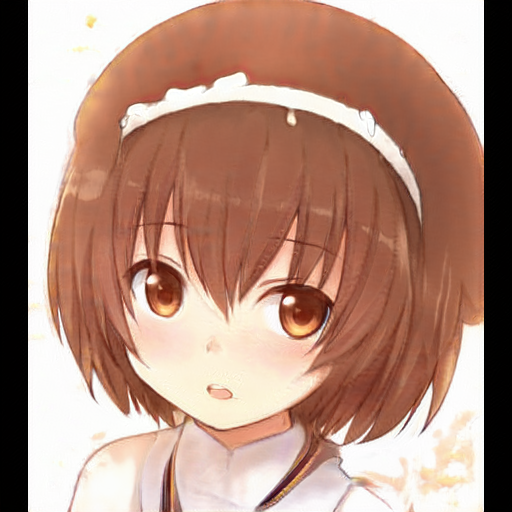

In [ ]:
imgs[0]

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

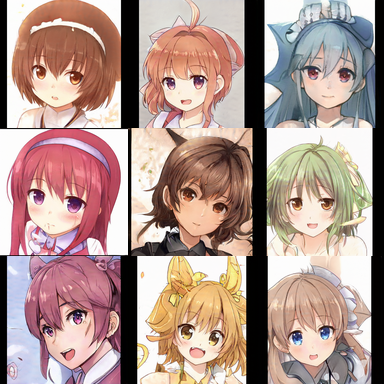

In [ ]:
createImageGrid(imgs, rows=3)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

7it [00:02,  2.57it/s]


7it [00:00,  7.59it/s]


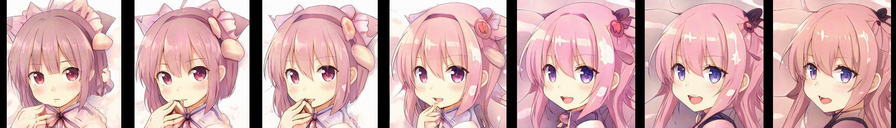

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2064384/45929032 bytes (4.5%)5455872/45929032 bytes (11.9%)8986624/45929032 bytes (19.6%)12632064/45929032 bytes (27.5%)16211968/45929032 bytes (35.3%)19439616/45929032 bytes (42.3%)23027712/45929032 bytes (50.1%)26468352/45929032 bytes (57.6%)29974528/45929032 bytes (65.3%)33341440/45929032 bytes (72.6%)36880384/45929032 bytes (80.3%)40517632/45929032 bytes (88.2%)

 99%|█████████▊| 75/76 [02:24<00:01,  1.92s/it]


In [ ]:
#video_clip.write_videofile("interpolate.mp4", fps=15, codec='libx264', bitrate='2M')
video_clip.write_gif(filename,fps=15)


[MoviePy] Building file random_grid_759.gif with imageio


 99%|█████████▊| 75/76 [02:25<00:01,  1.94s/it]


In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)